In [1]:
%matplotlib inline
from directSolve import DS
import numpy as np, matplotlib.pyplot as plt
import pystokes
import matelms as me

In [25]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 0.3, 2, 0.1
ds = DS(b, Np, eta)

S0, D0  = 0.0, 0.1      # strength of the stresslet (V2s) and potDipole (V3t)
forces  = pystokes.forceFields.Forces(particles=Np)

In [26]:
def rotation(vector,alpha, beta, gamma): ## wrong matrix?
    rotmat = np.array([[np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) 
                        - np.cos(alpha)*np.sin(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)
                        + np.sin(alpha)*np.sin(gamma)],
                       [np.cos(beta)*np.sin(gamma),
                        np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma),
                        np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)],
                       [-np.sin(beta),
                        np.sin(alpha)*np.cos(beta),
                        np.cos(alpha)*np.cos(beta)]])
    return np.dot(rotmat, vector)

In [27]:
## test rotation matrix
vector = np.array([0,0,1])
rotation(vector, np.pi/4, 0, 0)

array([ 0.        , -0.70710678,  0.70710678])

In [28]:
%%time
## Two active particles with orientations in positive z-direction, 
## falling next to each other under gravity: direct solver

#initial position
r = np.array([0.,1., 0.,0., 100.,100.])

#initial orientation
p = np.array([-1.,1., 0.,0., 0.,0.])

# external force and torque
F = np.array([0.,0., 0.,0., -0.,-0.])
T = np.array([0.,0., 0.,0.,  0., 0.]) 

# integration parameters
Nt=10; 
r1=np.zeros([3,Nt]); r2=np.zeros([3,Nt])
p1=np.zeros([3,Nt]); p2=np.zeros([3,Nt])

r1[:,0] = r[::Np]; r2[:,0] = r[1::Np]
p1[:,0] = p[::Np]; p2[:,0] = p[1::Np]

dt=3.;

v = np.zeros(3*Np);
o = np.zeros(3*Np)

theta1=np.zeros([3,Nt]); theta2=np.zeros([3,Nt])

v1 = np.zeros([3,Nt-1]); v2 = np.zeros([3,Nt-1])
o1 = np.zeros([3,Nt-1]); o2 = np.zeros([3,Nt-1])

# initial slip modes
S = np.zeros(5*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yy, yz
    S[i]       = S0*(3*p[i]*p[i] -1)
    S[i + Np]  = S0*(3*p[i]*p[i+Np])
    S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
    S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np]-1)
    S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
    
    D[i]       = D0*p[i]
    D[i+Np]    = D0*p[i+Np]
    D[i+2*Np]  = D0*p[i+2*Np]

for i in range(Nt-1):
    forces.lennardJones(F,r,lje=.6,ljr=0.3); ## good parameters?
    print('force on particle 1: ',F[::Np])
    ds.directSolve(v, o, r, F, T, S, D)
    
    #position
    r1[:,i+1] = r1[:,i] + dt*v[::Np]
    r2[:,i+1] = r2[:,i] + dt*v[1::Np]
    
    #angle (needed?)
    theta1[:,i+1] = theta1[:,i] + dt*o[::Np]
    theta2[:,i+1] = theta2[:,i] + dt*o[1::Np]
    
    #orientation
    p1[:,i+1] = rotation(p1[:,i], theta1[0,i+1], theta1[1,i+1], theta1[2,i+1])
    p2[:,i+1] = rotation(p2[:,i], theta2[0,i+1], theta2[1,i+1], theta2[2,i+1])
    
    #get velocity (constant for this case)
    v1[:,i] = v[::Np]
    v2[:,i] = v[1::Np]
    
    #get angular velocity (constant for this case)
    o1[:,i] = o[::Np]
    o2[:,i] = o[1::Np]
    
    # reset variables for next time step
    r[::Np] = r1[:,i+1]
    r[1::Np] = r2[:,i+1]
    v = v*0
    o = o*0
    
    # update slip for new orientation of particles
    S[0]       = S0*(3*p1[0,i+1]*p1[0,i+1] -1)
    S[0 + Np]  = S0*(3*p1[0,i+1]*p1[1,i+1])
    S[0 + 2*Np]= S0*(3*p1[0,i+1]*p1[2,i+1])
    S[0 + 3*Np]= S0*(3*p1[1,i+1]*p1[1,i+1]-1)
    S[0 + 4*Np]= S0*(3*p1[1,i+1]*p1[2,i+1])
    
    S[1]       = S0*(3*p2[0,i+1]*p2[0,i+1] -1)
    S[1 + Np]  = S0*(3*p2[0,i+1]*p2[1,i+1])
    S[1 + 2*Np]= S0*(3*p2[0,i+1]*p2[2,i+1])
    S[1 + 3*Np]= S0*(3*p2[1,i+1]*p2[1,i+1]-1)
    S[1 + 4*Np]= S0*(3*p2[1,i+1]*p2[2,i+1])
    
    D[0]       = D0*p1[0,i+1]
    D[0+Np]    = D0*p1[1,i+1]
    D[0+2*Np]  = D0*p1[2,i+1]
    
    D[1]       = D0*p2[0,i+1]
    D[1+Np]    = D0*p2[1,i+1]
    D[1+2*Np]  = D0*p2[2,i+1]

print('finish')

force on particle 1:  [0. 0. 0.]
force on particle 1:  [0. 0. 0.]
force on particle 1:  [0. 0. 0.]
force on particle 1:  [0. 0. 0.]
force on particle 1:  [0. 0. 0.]
force on particle 1:  [0. 0. 0.]
force on particle 1:  [0. 0. 0.]
force on particle 1:  [0. 0. 0.]
force on particle 1:  [0. 0. 0.]
finish
CPU times: user 878 ms, sys: 0 ns, total: 878 ms
Wall time: 127 ms


In [29]:
p1

array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00],
       [ 0.00000000e+00,  1.24505349e-15, -3.45597369e-15,
        -1.60550860e-14, -2.79156216e-14, -4.56898837e-14,
        -6.05326613e-14, -7.45753039e-14, -7.84702518e-14,
        -7.75397803e-14],
       [ 0.00000000e+00,  2.62599232e-17,  6.79245371e-17,
         1.12558539e-16,  1.53457868e-16,  1.81902804e-16,
         2.20207755e-16,  1.88722263e-16,  1.24949648e-16,
         1.80743752e-16]])

In [30]:
## velocity and angular velocity of particle 1
v1[:,0], o1[:,0]

(array([-1.99906327e-02,  3.96744140e-17,  2.63026193e-18]),
 array([-1.28760586e-18,  8.75330774e-18, -4.15017829e-16]))

In [31]:
## velocity and angular velocity of particle 2
v2[:,0], o2[:,0]

(array([ 1.99906327e-02,  3.96744140e-17, -2.63026193e-18]),
 array([-1.28760586e-18,  8.75330774e-18,  4.15017829e-16]))

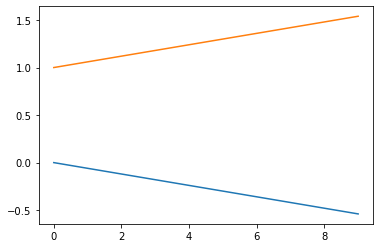

In [32]:
times = np.arange(0,Nt)
plt.plot(times, r1[0,:], times, r2[0,:])

In [ ]:
##model real squirmer 
## 3t mode behaves somewhat correctly, swims in direction of orientation
## 2s mode is attractive when orientations opposite here

In [9]:
## Test whether VH and K1sH give sensible things

In [18]:
D

array([ 0., -0., -0.,  0.,  0.,  0.])

In [19]:
i=0; j=1
xij = r[i]    - r[j]
yij = r[i+Np]  - r[j+Np]
zij = r[i+2*Np]  - r[j+2*Np]

xij, yij, zij

(-1.0, 1.182368943331709e-16, 0.0)

In [23]:
## effect of particle 2 on particle one: attraction? is K1sH correct?
VH = np.concatenate([S[::Np],D[::Np],np.zeros(14)]) 
np.dot(me.K1sH(xij,yij,zij, b,eta), VH)

array([0., 0., 0.])

In [21]:
VH[::Np]

array([-0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [97]:
p1 ##initial orientation vector of particle one

array([[-1.],
       [ 0.],
       [ 0.]])

In [98]:
0.2*D[::Np] ## self-propulsion to the left from p1

array([-0.002,  0.   ,  0.   ])

In [ ]:
## first check whether passive case is doing right thing...